In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple, Callable, Union, Optional
from tensor_type import Tensor
from scipy.stats import norm, expon, uniform, multivariate_normal
from torch import mm, exp, log, det, minimum, sqrt, mul, sin, cos
from torch.linalg import inv, det

import time
import pdb

In [2]:
# Plotting parameters
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

In [3]:
def improve_mass_matrix(minv: Tensor,
                        mu: Tensor,
                        n: int,
                        qs = List[Tensor]) -> Tensor:
    '''
    This function takes a list of the burn-in parameter points q
    and the current mass matrix to estimate an improved matrix
    minv: current mass matrix
    mu: mean of distribution
    n: number of burn-in points
    qs: lsit of parameter points
    returns the mean matrix of q.q^T summed with original Minv, and M
    '''
    #pdb.set_trace()
    minv = minv.clone()
    for i in range(n):
        a = qs[i] - mu  # create rank-1 matrix
        minv.add_(a.mm(a.t()))  # sum into minv
    minv.div_(n)
    return inv(minv), minv

# Unit Test
#test_list = [torch.tensor([[2.],[3.]]), torch.tensor([[1.],[4.]])]
#ident = torch.tensor([[1.,0.],[0.,1.]])
#zero = torch.zeros((2,1))
#improve_mass_matrix(ident,zero,2, test_list)

In [4]:
def KE(x:  Tensor,
       mu: Tensor,
       Minv: Optional[Tensor]=None,
       detM: Optional[float] =0.0) -> Tensor:
    '''
    This is a kinetic energy function KE(x) = -log pi(p|q), where
    pi is of general form xT.A.x
    x: is a point
    mu: is the distribution mean
    '''
    #pdb.set_trace()
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        ke = .5 * mm(x.t(), mm(Minv,x)) + const
    else:
        ke = .5 * mm(x.t(),x)
    #print(f'In KE: ke={ke}')
    return ke

def PE(x:  Tensor,
         mu: Tensor,
         Minv: Optional[Tensor] = None,
         detM: Optional[float] = 0.0) -> Tensor:
    '''
    -log pi(q) where pi(q) is Gaussian 
    '''
    #pdb.set_trace()
    a = x-mu
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        pe = .5 * mm(a.t(), mm(Minv,a)) + const
    else:
        pe = .5 * mm(a.t(),a)
    #print(f'In KE: ke={pe}')
    return pe

In [5]:
def get_autograd(func: Callable,
                 x:    Tensor,
                 mu:   Tensor,
                 Mat:  Tensor,
                 detMat: Optional[float] =0.0) -> Tuple[Tensor, Tensor]:
    '''
    dH calculates K(p) or V(q) along with associated gradient.
    x: is a tensor
    Mat: is a mass matrix
    func: is the K or V function to calculate
    returns function output and gradient
    '''
    #pdb.set_trace()
    x.requires_grad_(True) # track math operations
    x.retain_grad() # keep gradient after backward()
    out = func(x, mu, Mat, detMat)  # calculate given function
    out.backward(gradient=torch.ones(out.size()))  # Calculate grads
    x_grad = x.grad.data  # get gradients only
    x.grad = None  # reset gradient 
    x.requires_grad_(False)  # stop tracking
    return out.detach().clone(), x_grad 

# Unit Test
#t = torch.tensor([6., 4.]).view(2,1)
#tout, dt = dH(t, Minv, Tst2)

In [6]:
def stormer_verlet(V:    Callable,
                   q0:   Tensor,
                   p0:   Tensor,
                   mu:   Tensor,
                   Minv: Tensor,
                   eps:  float,
                   T:    int,
                   qpath,
                   ppath) -> Tuple[Tensor, Tensor]:
    '''
    Stormer-Verlet should propagate a point in phase space
    (p,q) according to Hamiltonian H.
    
    dVdq: references a function yielding the derivative of
    potential energy V.
    q0: is initial position tensor
    p0: is initial momentum tensor
    eps: scalar time increment
    T: time interval length
    qpath, ppath: temporary arrays for debugging
    returns numpy arrays q and p
    '''
    Nsteps = int(T//eps)
    q, p = q0.clone(), p0.clone()
    qpath[0] = q.item()
    ppath[0] = p.item()
    for n in range(Nsteps-1):
        #print(f'SV iter: {n}')
        _, dHdq = get_autograd(V, q, mu, Minv, detM)
        #print(f'In SV: first half dHdq={dHdq}')
        p -= eps * dHdq/2 # half momentum step
        q += eps * p # full parameter step
        qpath[n] = q.item()
        ppath[n] = p.item()
        
    _, dHdq = get_autograd(V, q, mu, Minv, detM)
    #print(f'In SV: second half dHdq={dHdq}')
    p -= eps * dHdq # full momentum step
    ppath[n+1] = p.item()

    return q,-p 

In [7]:
def acceptance(q0: Tensor,
               p0: Tensor,
               q:  Tensor,
               p:  Tensor,
               mu: Tensor,
               Minv: Optional[Tensor]=None) -> Tuple[Tensor, bool]:
    '''
    This function calculates the acceptance ratio for a proposal point.
    as min(1, exp(deltaE)) and checks this against a random uniform observer
    value. 
    q,q0,p,p0: Tensors
    mu: Tensor
    Minv: Tensor
    Returns a point and a boolean flag denoting accept or not accept
    '''
    #pdb.set_trace()
    KE0, PE0       = KE(q0, mu, Minv, detM) , PE(p0, mu, Minv, detM) 
    KEstar, PEstar = KE(q, mu, Minv, detM)  , PE(p, mu, Minv, detM)
    
    #print(f'ke0={KE0}   pe0={PE0}   ke*={KEstar}   pe*={PEstar}')
    ke_diff = exp((KE0 + PE0) - (KEstar + PEstar)).item()
    #print(f'E0-E = {ke_diff}')
    r = min(1., ke_diff)
    obs = uniform.rvs()
    #print(f'observer{obs} < {r} ratio')
    if obs < r:
        point = q
        acceptFlag = True
    else:
        point = q0
        acceptFlag = False
    return point, acceptFlag

## Test Run 0
### Setup<br>
* Target distribution is a standard normal Gaussian
* Initial sample $q0 = .01$ near the mode of the Gaussian
* Momentum is independently sampled from a Std Normal dist for p0
* 100 proposals are made

### Note<br>
* Starting from $q0\in\mathcal{Q}$ within the target distribution near mode gives good exploration/mixing in 100 proposals.
* Each valid sampling of $(q0,p0)$ gives a level set orbit or ring on the Gaussian in the phase space defined by position x momentum,
$$\mathcal{Q}\times\mathcal{P}$$.

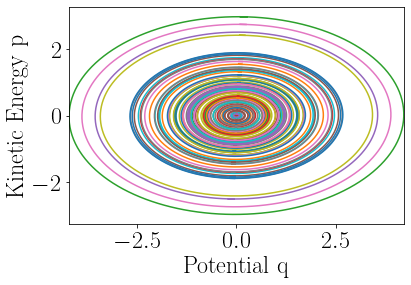

Acceptance rate: 1.0




In [10]:
T = 9.  # Full time-steps
eps = 0.03  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 100  # Number of q's to test 
D = 1  # Dimension of q
M = torch.tensor([[1.]])
Minv = inv(M)
detM = det(M).type(torch.float32)
mu = torch.tensor([[0.]],dtype=torch.float32)

accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic
allPaths = qPath = torch.zeros((Nq, Nsteps, D))
pathFlag = []

# pre-select random q's
Q0 = np.array([[.01]])

# Loop iterations
for n in range(Nq):
    qpath = np.zeros(Nsteps)
    ppath = np.zeros(Nsteps)
    #print(f'Outer loop: {n}')
    #qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    q0 = torch.from_numpy(Q0).reshape((D,1)).type(torch.float32)
    # sample momentum p0 from normal
    sample = norm.rvs(size=D)
    p0 = torch.from_numpy(sample).type(torch.float32).view(D,1)
    # q0,p0 are (2,1) tensors
    #print(f'Shape q value {q0}  p value {p0}')
    q, p = stormer_verlet(PE, q0, p0, mu, Minv, eps, T, qpath, ppath)
    q1, aFlag = acceptance(q0, p0, q, p, mu, Minv)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
    else:
        rejected +=1
    #pathFlag.append(aFlag)
    #allPaths[n,:,:] = qPath[:,:]
    plt.plot(qpath[:-1],ppath[:-1])
    Q0 = q0.numpy()
plt.xlabel('Potential q')
plt.ylabel('Kinetic Energy p')
plt.show()
print(f'Acceptance rate: {accepted/Nq}\n\n')    

## Test Run 1
### Setup
* Changed $q0=4.$ which is in a tail of the 1D Gaussian

### Notes
* In 100 proposals as above the Gaussian was not well explored/mixed
* The model becomes stuck in the tails of the distribution

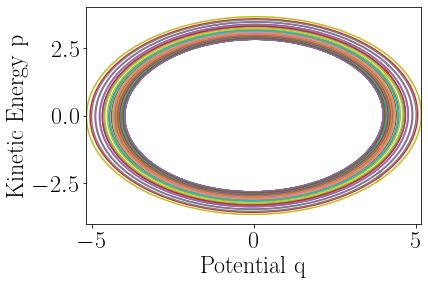

Acceptance rate: 0.98




In [11]:
T = 9.  # Full time-steps
eps = 0.03  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 100  # Number of q's to test 
D = 1  # Dimension of q
M = torch.tensor([[1.]])
Minv = inv(M)
detM = det(M).type(torch.float32)
mu = torch.tensor([[0.]],dtype=torch.float32)

accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic

pathFlag = []

# pre-select random q's
Q0 = np.array([[4.]])#np.random.uniform(low=-4., high=4., size=(D,Nq)) #(2,100)

# Loop iterations
for n in range(Nq):
    qpath = np.zeros(Nsteps)
    ppath = np.zeros(Nsteps)
    #print(f'Outer loop: {n}')
    #qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    q0 = torch.from_numpy(Q0).reshape((D,1)).type(torch.float32)
    # sample momentum p0 from normal
    sample = norm.rvs(size=D)
    p0 = torch.from_numpy(sample).type(torch.float32).view(D,1)
    # q0,p0 are (2,1) tensors
    #print(f'Shape q value {q0}  p value {p0}')
    q, p = stormer_verlet(PE, q0, p0, mu, Minv, eps, T, qpath, ppath)
    q1, aFlag = acceptance(q0, p0, q, p, mu, Minv)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
    else:
        rejected +=1
    #pathFlag.append(aFlag)
    #allPaths[n,:,:] = qPath[:,:]
    plt.plot(qpath[:-1],ppath[:-1])
    Q0 = q0.numpy()
plt.xlabel('Potential q')
plt.ylabel('Kinetic Energy p')
plt.show()
print(f'Acceptance rate: {accepted/Nq}\n\n')    

## Test Run 3
### Setup
* Reduced sigma to $\sigma=.1$
* Start from $q0=4.$ in tails of target distribution and $q0=.01$ near mode

### Notes
* No exploration/mixing when starting outside the distribution
* Well explored/mixed starting from within

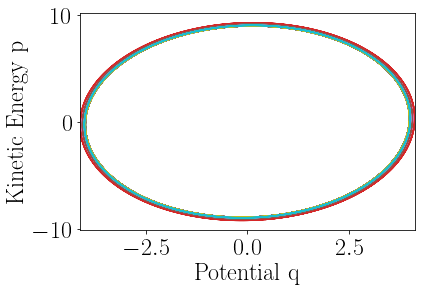

Acceptance rate: 0.0




In [12]:
T = 9.  # Full time-steps
eps = 0.03  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 100  # Number of q's to test 
D = 1  # Dimension of q
M = torch.tensor([[.1]])
Minv = inv(M)
detM = det(M).type(torch.float32)
mu = torch.tensor([[0.]],dtype=torch.float32)

accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic

pathFlag = []

# pre-select random q's
Q0 = np.array([[4.]])#np.random.uniform(low=-4., high=4., size=(D,Nq)) #(2,100)

# Loop iterations
for n in range(Nq):
    qpath = np.zeros(Nsteps)
    ppath = np.zeros(Nsteps)
    #print(f'Outer loop: {n}')
    #qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    q0 = torch.from_numpy(Q0).reshape((D,1)).type(torch.float32)
    # sample momentum p0 from normal
    sample = norm.rvs(size=D)
    p0 = torch.from_numpy(sample).type(torch.float32).view(D,1)
    # q0,p0 are (2,1) tensors
    #print(f'Shape q value {q0}  p value {p0}')
    q, p = stormer_verlet(PE, q0, p0, mu, Minv, eps, T, qpath, ppath)
    q1, aFlag = acceptance(q0, p0, q, p, mu, Minv)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
    else:
        rejected +=1
    #pathFlag.append(aFlag)
    #allPaths[n,:,:] = qPath[:,:]
    plt.plot(qpath[:-1],ppath[:-1])
    Q0 = q0.numpy()
plt.xlabel('Potential q')
plt.ylabel('Kinetic Energy p')
plt.show()
print(f'Acceptance rate: {accepted/Nq}\n\n')    

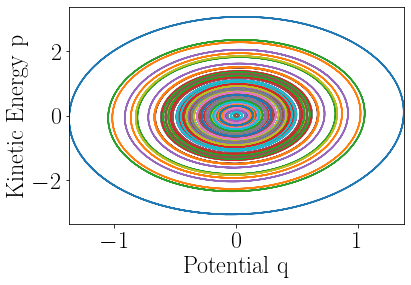

Acceptance rate: 1.0




In [13]:
T = 9.  # Full time-steps
eps = 0.03  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 100  # Number of q's to test 
D = 1  # Dimension of q
M = torch.tensor([[.1]])
Minv = inv(M)
detM = det(M).type(torch.float32)
mu = torch.tensor([[0.]],dtype=torch.float32)

accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic

pathFlag = []

# pre-select random q's
Q0 = np.array([[.01]])#np.random.uniform(low=-4., high=4., size=(D,Nq)) #(2,100)

# Loop iterations
for n in range(Nq):
    qpath = np.zeros(Nsteps)
    ppath = np.zeros(Nsteps)
    #print(f'Outer loop: {n}')
    #qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    q0 = torch.from_numpy(Q0).reshape((D,1)).type(torch.float32)
    # sample momentum p0 from normal
    sample = norm.rvs(size=D)
    p0 = torch.from_numpy(sample).type(torch.float32).view(D,1)
    # q0,p0 are (2,1) tensors
    #print(f'Shape q value {q0}  p value {p0}')
    q, p = stormer_verlet(PE, q0, p0, mu, Minv, eps, T, qpath, ppath)
    q1, aFlag = acceptance(q0, p0, q, p, mu, Minv)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
    else:
        rejected +=1
    #pathFlag.append(aFlag)
    #allPaths[n,:,:] = qPath[:,:]
    plt.plot(qpath[:-1],ppath[:-1])
    Q0 = q0.numpy()
plt.xlabel('Potential q')
plt.ylabel('Kinetic Energy p')
plt.show()
print(f'Acceptance rate: {accepted/Nq}\n\n')    

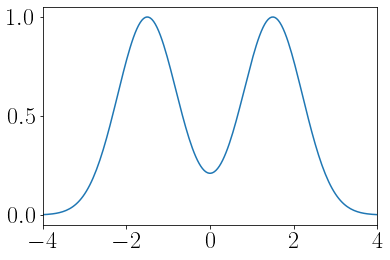

In [36]:
x = np.linspace(-4,4,200)
y = np.exp(-(x-1.5)**2) + np.exp(-(x+1.5)**2)
plt.plot(x,y)
plt.show()

In [37]:
def PE2(x:  Tensor,
         mu: Tensor,
         Minv: Optional[Tensor] = None,
         detM: Optional[float] = 0.0) -> Tensor:
    '''
    -log pi(q) where pi(q) is Gaussian 
    '''
    #pdb.set_trace()
    a = x-mu
    if(torch.is_tensor(Minv)):
        pe = - log(exp(-(x-1.5)**2) + exp(-(x+1.5)**2))
    else:
        pe = -log(exp(-(x-1.5)**2) + exp(-(x+1.5)**2))
    #print(f'In KE: ke={pe}')
    return pe

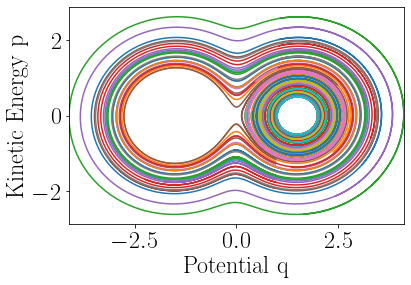

Acceptance rate: 0.85




In [39]:
T = 12.  # Full time-steps
eps = 0.03  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 100  # Number of q's to test 
D = 1  # Dimension of q
M = torch.tensor([[4.]])
Minv = inv(M)
detM = det(M).type(torch.float32)
mu = torch.tensor([[0.]],dtype=torch.float32)

accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic

pathFlag = []

# pre-select random q's
Q0 = np.array([[1.]])#np.random.uniform(low=-4., high=4., size=(D,Nq)) #(2,100)

# Loop iterations
for n in range(Nq):
    qpath = np.zeros(Nsteps)
    ppath = np.zeros(Nsteps)
    #print(f'Outer loop: {n}')
    #qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    q0 = torch.from_numpy(Q0).reshape((D,1)).type(torch.float32)
    # sample momentum p0 from normal
    sample = norm.rvs(size=D)
    p0 = torch.from_numpy(sample).type(torch.float32).view(D,1)
    # q0,p0 are (2,1) tensors
    #print(f'Shape q value {q0}  p value {p0}')
    q, p = stormer_verlet(PE2, q0, p0, mu, Minv, eps, T, qpath, ppath)
    q1, aFlag = acceptance(q0, p0, q, p, mu, Minv)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
    else:
        rejected +=1
    #pathFlag.append(aFlag)
    #allPaths[n,:,:] = qPath[:,:]
    plt.plot(qpath[:-1],ppath[:-1])
    Q0 = q0.numpy()
plt.xlabel('Potential q')
plt.ylabel('Kinetic Energy p')
plt.show()
print(f'Acceptance rate: {accepted/Nq}\n\n')    

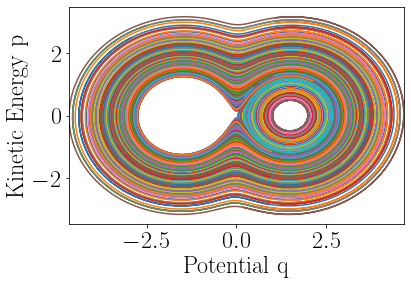

Acceptance rate: 0.835




In [40]:
T = 12.  # Full time-steps
eps = 0.03  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 1000  # Number of q's to test 
D = 1  # Dimension of q
M = torch.tensor([[4.]])
Minv = inv(M)
detM = det(M).type(torch.float32)
mu = torch.tensor([[0.]],dtype=torch.float32)

accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic

pathFlag = []

# pre-select random q's
Q0 = np.array([[1.]])#np.random.uniform(low=-4., high=4., size=(D,Nq)) #(2,100)

# Loop iterations
for n in range(Nq):
    qpath = np.zeros(Nsteps)
    ppath = np.zeros(Nsteps)
    #print(f'Outer loop: {n}')
    #qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    q0 = torch.from_numpy(Q0).reshape((D,1)).type(torch.float32)
    # sample momentum p0 from normal
    sample = norm.rvs(size=D)
    p0 = torch.from_numpy(sample).type(torch.float32).view(D,1)
    # q0,p0 are (2,1) tensors
    #print(f'Shape q value {q0}  p value {p0}')
    q, p = stormer_verlet(PE2, q0, p0, mu, Minv, eps, T, qpath, ppath)
    q1, aFlag = acceptance(q0, p0, q, p, mu, Minv)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
    else:
        rejected +=1
    #pathFlag.append(aFlag)
    #allPaths[n,:,:] = qPath[:,:]
    plt.plot(qpath[:-1],ppath[:-1])
    Q0 = q0.numpy()
plt.xlabel('Potential q')
plt.ylabel('Kinetic Energy p')
plt.show()
print(f'Acceptance rate: {accepted/Nq}\n\n')    